# 通过 PyTorch 构建神经网络

下面我们将了解如何使用 PyTorch 构建神经网络。

In [1]:
# Import things like usual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #导入软件包，与PyTorch相关使能下载并使用一些现有的数据集

首先，我们需要获取数据集。这些数据位于 `torchvision` 软件包中。以下代码将下载 MNIST 数据集，然后为我们创建训练数据集和测试数据集。暂时不用对细节部分太关心，稍后你会详细学习的。

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
#首先将图像转换为PyTorch张量 然后标准化（normalize）:
#对这些灰阶图像进行处理，每个像素值是从0到1的浮点数 变为从（方差范围）-1到1（减0.5）（均值）
#从每个颜色通道【0-1】（即每个像素减去0.5【-0.5 - 0.5】 然后除以0.5【乘以2】）

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
#用torchvision下载并加载训练数据 如果磁盘上没有该数据那将下载之，提供转换：
#读取这些图像然后应用这些转换生成传入网络的数据集

#使用的数据集称为MNIST，一堆手写数字0-9的图像
#此数据集用于训练网络或其他机器学习模型，使它们能够将图像分类为数字
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
#批次大小设为64：当从trainloader获取数据时 每次将获得64张图像

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

我们将训练数据加载到了 `trainloader` 中，并使用 `iter(trainloader)`使其变成迭代器。我们将用它循环访问数据集以进行训练，但是现在我只获取了第一批数据，以便查看数据。从下方可以看出，`images` 是一个大小为 (64, 1, 28, 28) 的张量。因此，每批有 64 个图像、1 个颜色通道，共有 28x28 个图像。
》MNIST图像28x28,(的向量)=784输入层

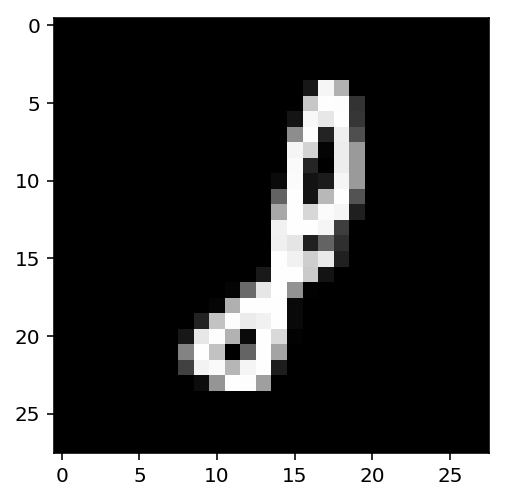

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')

## 通过 PyTorch 构建神经网络

我将使用 PyTorch 构建一个简单的前馈网络，用于对 MNIST 图像进行分类。即该网络将接收数字图像作为输入，并预测图像中的数字。》输出层 10个数字，层级中的单元或层级越多 越能拟合数据
》对于激活函数，隐藏层ReLu 输出层softmax(接受这些输出单元的值并将之转换为概率分布)
》离散概率分布，表示输入属于这个类别softmax的概率

<img src="assets/mlp_mnist.png" width=600px>

要通过 PyTorch 构建神经网络，你需要使用 `torch.nn` 模块。网络本身是继承自 `torch.nn.Module` 的类。你需要单独定义每个运算，例如针对具有 784 个输入和 128 个单元的全连接层定义为 `nn.Linear(784, 128)`。

该类需要包含对网络实现前向传递的 `forward` 方法。在此方法中，你将对之前定义的每个运算传递输入张量 `x`。`torch.nn` 模块在 `torch.nn.functional` 中还具有一些对等的功能，例如 ReLU。此模块通常导入为 `F`。要对某个层（只是一个张量）使用 ReLU 激活函数，你需要使用 `F.relu(x)`。以下是一些常见的不同激活函数。

<img src="assets/activation.png" width=700px>

对于此网络，我将添加三个全连接层，然后添加一个预测类别的 softmax 输出。softmax 函数和 S 型函数相似，都会将输入调整到 0 到 1 之间，但是还会标准化这些输入，以便所有值的和为 1，就像正常的概率分布一样。

》损失函数：交叉熵损失函数cross entropy loss：将softmax层的概率或预测 与真实类别进行比较
》然后使用二者之差（即损失）更新网络中的权重

In [5]:
from torch import nn #神经网络函数（模块）
from torch import optim
import torch.nn.functional as F #跟多专门针对神经网络的函数 函数形式
from torch.autograd import Variable

In [6]:
class Network(nn.Module): #这个类Network 是nn.Module 的子类
    def __init__(self):
        super().__init__()  #super()：调用此子类所继承的类的函数或属性
        #调用nn.Module的init方法
        
        # Defining the layers, 128, 64, 10 units each #定义要使用的层级，神经网络架构的运算
        self.fc1 = nn.Linear(784, 128) #表示全连接层 6：22
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits)

net = Network()
net

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### 初始化权重和偏差

权重等参数是系统自动初始化的，但是你也可以自定义如何初始化这些权重。权重和偏差是附加到你所定义的层的张量，你可以通过 `net.fc1.weight` 获取它们。

In [7]:
print(net.fc1.weight)
print(net.fc1.bias)

Parameter containing:
tensor([[ 5.6106e-03, -1.8561e-03,  3.2211e-02,  ..., -3.2147e-02,
          1.3159e-02,  2.8102e-02],
        [ 1.4691e-02,  1.4644e-02,  9.2946e-03,  ..., -2.3313e-02,
          3.3801e-02,  1.3908e-02],
        [ 8.5832e-03, -3.0571e-02,  8.3739e-03,  ..., -2.3222e-02,
          3.4756e-02, -1.7155e-02],
        ...,
        [ 1.3019e-02, -1.2791e-02,  2.3978e-02,  ..., -6.2585e-03,
          3.0470e-02, -2.2942e-02],
        [-4.2310e-03, -1.5862e-03,  1.0516e-02,  ...,  3.3391e-02,
         -1.7527e-02,  3.0094e-02],
        [ 1.2858e-02,  2.4963e-02, -2.8564e-02,  ..., -3.3943e-02,
          1.5689e-02, -2.1550e-02]])
Parameter containing:
tensor(1.00000e-02 *
       [-2.3458, -0.4653,  3.0212,  1.8113,  0.5801,  1.5518, -1.5412,
         2.6466, -3.3192,  2.5159, -2.3186,  0.5840, -0.3030,  0.9004,
         3.0032,  1.4141, -3.3963, -2.8561,  0.6840,  0.5012,  2.8190,
         2.9609,  2.7853,  1.5385, -0.8942, -2.0748, -2.2644, -1.1862,
         3.3283,  3

要自定义初始化过程，请原地修改这些张量。实际上存在 autograd *变量*，因此我们需要通过 `net.fc1.weight.data` 获取真正的张量。获得张量后，可以用 0（针对偏差）或随机正常值填充这些张量。

In [8]:
# Set biases to all zeros
net.fc1.bias.data.fill_(0);

In [9]:
# sample from random normal with standard dev = 0.01
net.fc1.weight.data.normal_(std=0.01);

### 前向传递

我们已经创建好网络，看看传入图像后会发生什么。这一过程称之为前向传递。我们将图像数据转换为张量，然后传递给网络架构定义的运算。

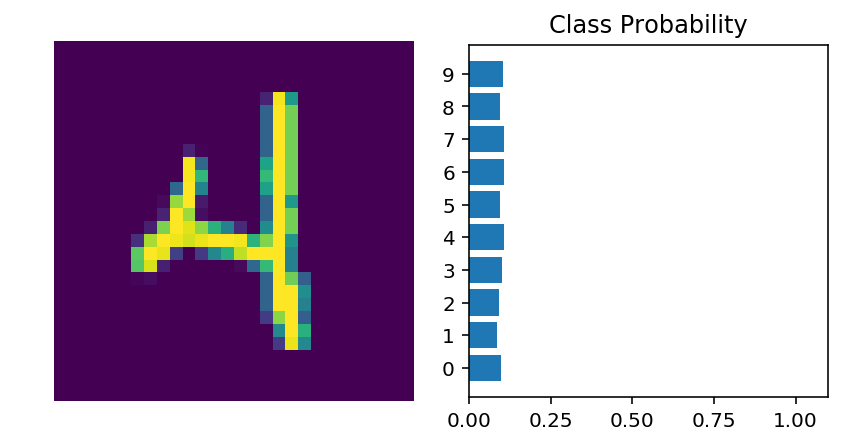

In [10]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.resize_(64, 1, 784)

# Need to wrap it in a Variable, will explain in next notebook
inputs = Variable(images) 

# Forward pass through the network
img_idx = 0
logits = net.forward(inputs[img_idx,:])

# Predict the class from the network output
ps = F.softmax(logits, dim=1)

img = images[img_idx]
helper.view_classify(img.resize_(1, 28, 28), ps)

从上图中可以看出，我们的网络基本上根本不知道这个数字是什么，因为我们还没训练它，所有权重都是随机的！接下来，我们将了解如何训练该网络，使其能学习如何正确地对这些数字进行分类。